In [1]:
import sklearn as skl
import sklearn.datasets
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plot
import os,ssl
import sys

In [12]:
class MLPN(object):
    
    def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001,shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        L2_term = (self.l2 *(np.sum(self.w_h ** 2.) + np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        return cost

    def predict(self, X):
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0,
        scale=0.1,
        size=(n_features, self.n_hidden))

        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0,
        scale=0.1,
        size=(self.n_hidden, n_output))
        epoch_strlen = len(str(self.epochs))
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        y_train_enc = self._onehot(y_train, n_output)

        for i in range(self.epochs):
            indices = np.arange(X_train.shape[0])
            if self.shuffle:
                self.random.shuffle(indices)
                for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                    batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                    z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                    
                    delta_out = a_out - y_train_enc[batch_idx]
                    sigmoid_derivative_h = a_h * (1. - a_h)                   
                    delta_h = (np.dot(delta_out, self.w_out.T) * sigmoid_derivative_h)
                    
                    grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                    grad_b_h = np.sum(delta_h, axis=0)
                    
                    grad_w_out = np.dot(a_h.T, delta_out)
                    grad_b_out = np.sum(delta_out, axis=0)
 
                    delta_w_h = (grad_w_h + self.l2*self.w_h)
                    delta_b_h = grad_b_h
 
                    self.w_h -= self.eta * delta_w_h
                    self.b_h -= self.eta * delta_b_h
        
                    delta_w_out = (grad_w_out + self.l2*self.w_out)
                    delta_b_out = grad_b_out
 
                    self.w_out -= self.eta * delta_w_out
                    self.b_out -= self.eta * delta_b_out

            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)
                                      
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
                                      
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
                                      
            print(f"\r{i+1:d}/{self.epochs:d} | Cost: {cost:.2f} | Train/Valid Acc.: {train_acc}/{valid_acc}")
                                      
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self                                     

In [15]:
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

X, y = skl.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
indices = np.arange(len(y))
X = ((X / 255.) - .5) * 2
X1 = X
X_tr, X_t, y_tr, y_t = skl.model_selection.train_test_split(X1, y, test_size=0.3)

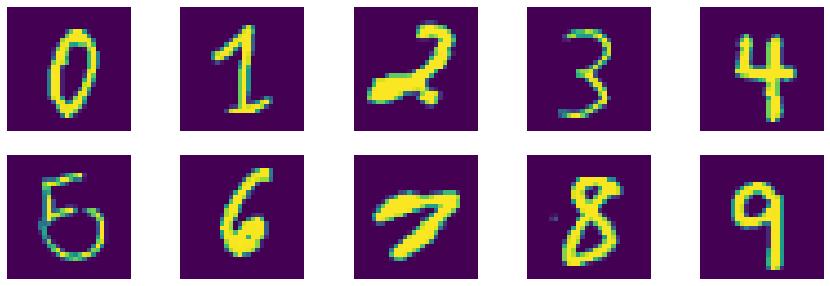

In [17]:
fig, axs = plot.subplots(2,5,figsize = (15, 5))
for i in range(2):
    for j in range(5):
        img = X_tr[y_tr==i*5+j][0].reshape(28,28)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
plot.show()

In [18]:
nn = MLPN(n_hidden=100, l2=0.01, epochs=200, eta=0.0005, minibatch_size=100, shuffle=True,seed=1)

In [19]:
nn.fit(X_train=X_tr[:55000], y_train=y_tr[:55000], X_valid=X_tr[55000:], y_valid=y_tr[55000:])

C:\Users\adeoy\anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


1/200 | Cost: 62186.88 | Train/Valid Acc.:
2/200 | Cost: 44063.72 | Train/Valid Acc.:
3/200 | Cost: 36823.72 | Train/Valid Acc.:
4/200 | Cost: 33085.65 | Train/Valid Acc.:
5/200 | Cost: 30344.15 | Train/Valid Acc.:
6/200 | Cost: 28467.57 | Train/Valid Acc.:
7/200 | Cost: 26816.44 | Train/Valid Acc.:
8/200 | Cost: 25581.14 | Train/Valid Acc.:
9/200 | Cost: 24632.74 | Train/Valid Acc.:
10/200 | Cost: 23600.30 | Train/Valid Acc.:
11/200 | Cost: 22737.62 | Train/Valid Acc.:
12/200 | Cost: 21974.22 | Train/Valid Acc.:
13/200 | Cost: 21366.37 | Train/Valid Acc.:
14/200 | Cost: 20784.05 | Train/Valid Acc.:
15/200 | Cost: 20390.03 | Train/Valid Acc.:
16/200 | Cost: 19649.49 | Train/Valid Acc.:
17/200 | Cost: 19145.48 | Train/Valid Acc.:
18/200 | Cost: 18697.28 | Train/Valid Acc.:
19/200 | Cost: 18238.61 | Train/Valid Acc.:
20/200 | Cost: 17826.18 | Train/Valid Acc.:
21/200 | Cost: 17448.52 | Train/Valid Acc.:
22/200 | Cost: 17167.52 | Train/Valid Acc.:
23/200 | Cost: 16768.79 | Train/Valid Acc

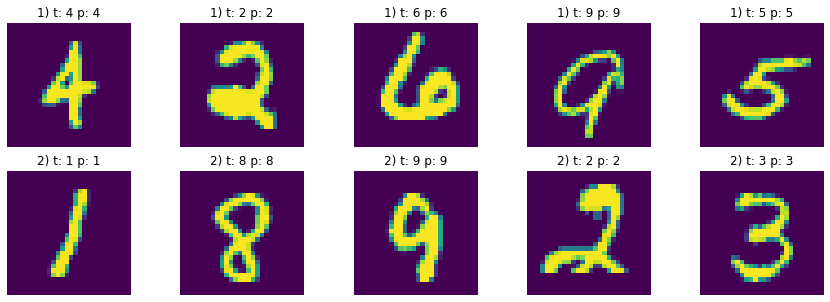

In [22]:
y_test_pred = nn.predict(X_t)
fig1, axs1 = plot.subplots(2,5,figsize = (15, 5))
img1 = X_t[y_t == y_test_pred][:10]
c_lab = y_t[y_t == y_test_pred][:10]
c_lab = c_lab
p_lab = y_test_pred[y_t == y_test_pred][:10]
for i in range(2):
    for j in range(5):
        axs1[i,j].imshow(img1[i*5+j].reshape(28,28))
        axs1[i,j].set_title('%d) t: %d p: %d'% (i+1, c_lab[i*5+j], p_lab[i*5+j])) 
        axs1[i,j].axis('off')
plot.show()

In [23]:
pip install tensorflow

ERROR: pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
ERROR: pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
ERROR: astroid 2.3.3 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\adeoy\\anaconda3\\lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=8eb36bbe5cd39fa244b561208b38cbc39ad5db1ab6ddf2cf6b91ecfd9b5d92dd
  Stored in directory: c:\users\adeoy\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built termcolor
  Attempting uninstall: six
    Found existing installation: six 1.14.0
    Uninstalling six-1.14.0:
      Successfully uninstalled six-1.14.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
